In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import open_clip
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.datasets import CIFAR10
from tqdm import tqdm
from transformers import CLIPModel, CLIPTokenizer

/opt/anaconda3/envs/deepbench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Config
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# Parameters
batch_size = 128
model_name = "ViT-L-14"
pretrained = "openai"
num_batches = 5



In [3]:
# Load Hugging Face model
hf_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device).eval()
hf_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

In [4]:
# Load OpenCLIP model
openclip_model, _, _ = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
openclip_model = openclip_model.to(device).eval()
openclip_tokenizer = open_clip.get_tokenizer(model_name)

/opt/anaconda3/envs/deepbench/lib/python3.11/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [5]:
# Load CIFAR-10
_, preprocess, _ = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
testset = CIFAR10(root="./data", train=False, download=True, transform=preprocess)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
class_names = testset.classes

Files already downloaded and verified


In [6]:
# Get text embeddings once
with torch.no_grad():
    text_inputs_hf = hf_tokenizer(class_names, return_tensors="pt", padding=True).to(device)
    text_features_hf = hf_model.get_text_features(**text_inputs_hf)
    text_features_hf /= text_features_hf.norm(dim=-1, keepdim=True)

    text_inputs_oc = openclip_tokenizer(class_names).to(device)
    text_features_oc = openclip_model.encode_text(text_inputs_oc)
    text_features_oc /= text_features_oc.norm(dim=-1, keepdim=True)

In [7]:
# limit batch number - but evaluate on the exact same batches
batches = []
for i, batch in enumerate(testloader):
    if i >= num_batches:
        break
    batches.append(batch)

In [8]:
# === Evaluation: Hugging Face ===
y_true_hf, y_pred_hf = [], []
start = time.time()

for images, labels in tqdm(batches, desc="Hugging Face Inference"):
    y_true_hf.extend(labels.numpy())
    images = images.to(device)

    with torch.no_grad():
        image_features = hf_model.get_image_features(pixel_values=images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = image_features @ text_features_hf.T
        preds = similarity.argmax(dim=1).cpu().numpy()
        y_pred_hf.extend(preds)

elapsed_hf = time.time() - start
acc_hf = (np.array(y_true_hf) == np.array(y_pred_hf)).mean() * 100

Hugging Face Inference: 100%|██████████| 5/5 [00:38<00:00,  7.70s/it]


In [9]:
# === Evaluation: OpenCLIP ===
y_true_oc, y_pred_oc = [], []
start = time.time()

for images, labels in tqdm(batches, desc="OpenCLIP Inference"):
    y_true_oc.extend(labels.numpy())
    images = images.to(device)

    with torch.no_grad():
        image_features = openclip_model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = image_features @ text_features_oc.T
        preds = similarity.argmax(dim=1).cpu().numpy()
        y_pred_oc.extend(preds)

elapsed_oc = time.time() - start
acc_oc = (np.array(y_true_oc) == np.array(y_pred_oc)).mean() * 100

OpenCLIP Inference: 100%|██████████| 5/5 [00:37<00:00,  7.55s/it]


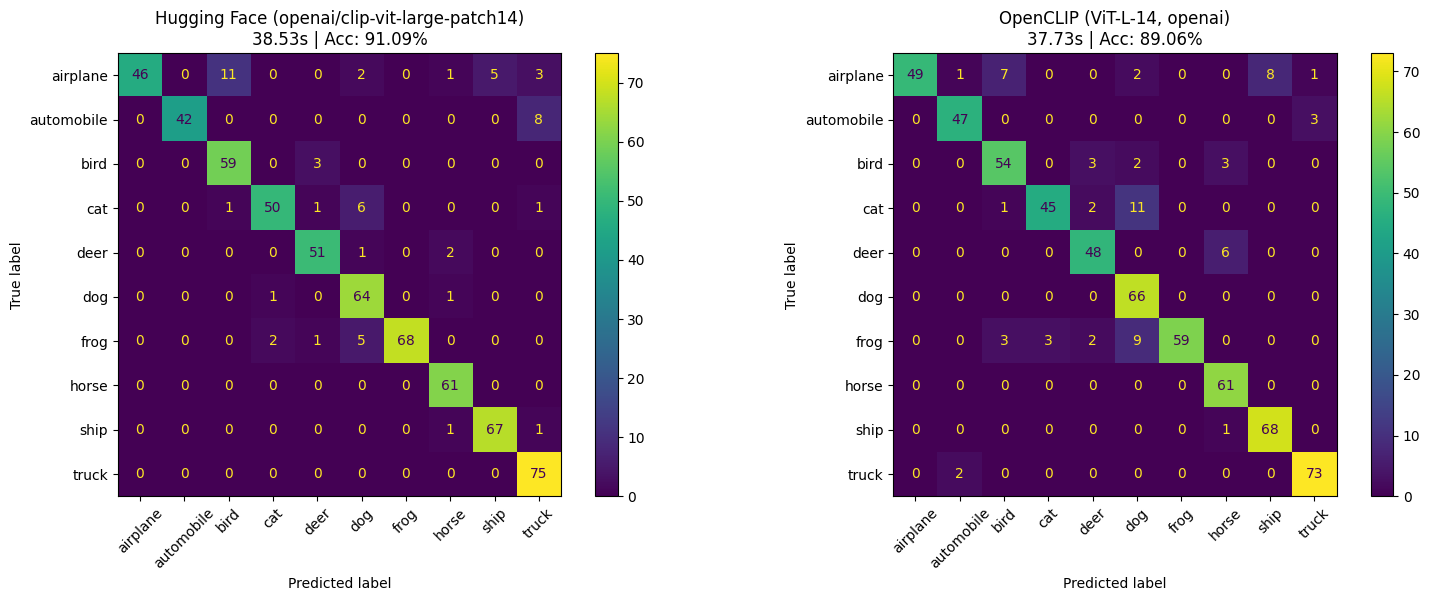

In [10]:
# === Plot confusion matrices ===
cm_hf = confusion_matrix(y_true_hf, y_pred_hf)
cm_oc = confusion_matrix(y_true_oc, y_pred_oc)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ConfusionMatrixDisplay(cm_hf, display_labels=class_names).plot(ax=axes[0], xticks_rotation=45)
axes[0].set_title(f"Hugging Face (openai/clip-vit-large-patch14)\n{elapsed_hf:.2f}s | Acc: {acc_hf:.2f}%")

ConfusionMatrixDisplay(cm_oc, display_labels=class_names).plot(ax=axes[1], xticks_rotation=45)
axes[1].set_title(f"OpenCLIP ({model_name}, {pretrained})\n{elapsed_oc:.2f}s | Acc: {acc_oc:.2f}%")

plt.tight_layout()
plt.savefig("openclip_vs_huggingface.png", dpi=300, bbox_inches='tight')
plt.show()